# 1. Forecast claim costs for better business planning

## Basic

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('healthcare_dataset.csv')

df = df.drop(columns=['Name', 'Date of Admission', 'Discharge Date', 'Doctor', 'Hospital', 'Insurance Provider', 'Medication', 'Test Results'])

categorical_columns = ['Gender', 'Blood Type', 'Medical Condition', 'Admission Type']

label_encoder = LabelEncoder()

for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

X = df.drop(columns=['Billing Amount'])
y = df['Billing Amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')


Mean Absolute Error: 12011.976479859113
Mean Squared Error: 202379131.64876878
Root Mean Squared Error: 14226.001955882362


## Advanced

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'model__n_estimators': 100, 'model__min_samples_split': 10, 'model__min_samples_leaf': 4, 'model__max_features': 'log2', 'model__max_depth': 20, 'model__bootstrap': False}
Mean Absolute Error: 12238.558981751048
Mean Squared Error: 205802996.49263588
Root Mean Squared Error: 14345.835510441206


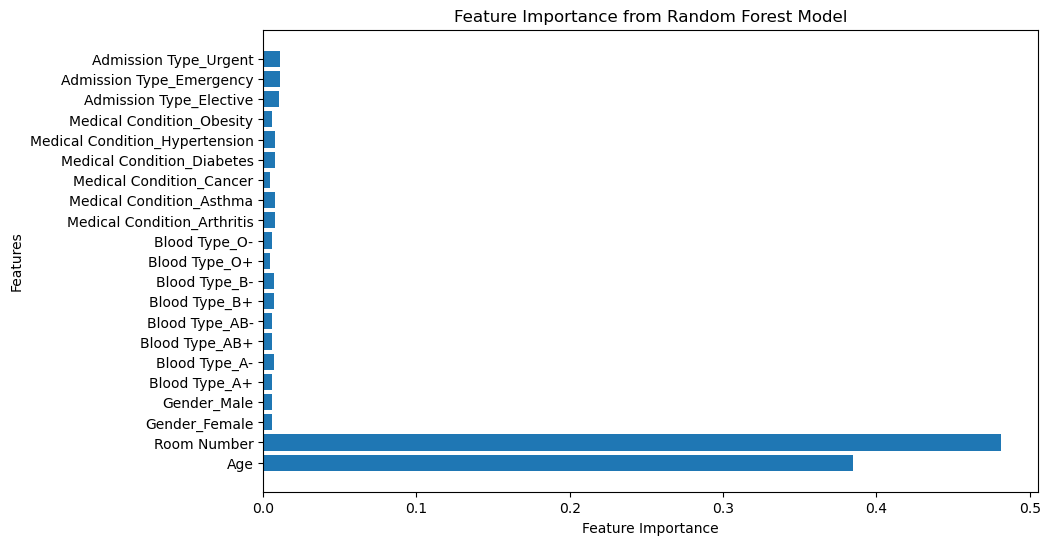

Cross-validation MAE scores: [-12309.12341456 -12472.59052899 -12346.14044006 -12466.66868388
 -12402.49181832]
Mean CV MAE: 12399.40297716158


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import joblib
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('healthcare_dataset.csv')

# Drop unnecessary columns
df = df.drop(columns=['Name', 'Date of Admission', 'Discharge Date', 'Doctor', 'Hospital', 'Insurance Provider', 'Medication', 'Test Results'])

# Define categorical and numerical columns
categorical_columns = ['Gender', 'Blood Type', 'Medical Condition', 'Admission Type']
numerical_columns = ['Age', 'Room Number']

# Separate features (X) and target (y)
X = df.drop(columns=['Billing Amount'])
y = df['Billing Amount']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessor for numerical and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ])

# Create pipeline with RandomForestRegressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

# Define parameter grid for RandomizedSearchCV
param_distributions = {
    'model__n_estimators': [100, 200, 300, 400],
    'model__max_depth': [None, 10, 20, 30, 50],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['auto', 'sqrt', 'log2'],
    'model__bootstrap': [True, False],
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline, param_distributions, n_iter=10, cv=5, verbose=2, random_state=42, n_jobs=-1, scoring='neg_mean_absolute_error')

# Train the model
random_search.fit(X_train, y_train)

# Display best parameters
print(f"Best parameters: {random_search.best_params_}")

# Evaluate the model
y_pred = random_search.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

# Save the trained model
# joblib.dump(random_search.best_estimator_, 'random_forest_model_tuned.pkl')

# Plot feature importance
importances = random_search.best_estimator_.named_steps['model'].feature_importances_
encoded_columns = random_search.best_estimator_.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_columns)
features = numerical_columns + list(encoded_columns)

plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from Random Forest Model')
plt.show()

# Cross-validation for generalization evaluation
cv_scores = cross_val_score(random_search.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print(f"Cross-validation MAE scores: {cv_scores}")
print(f"Mean CV MAE: {-cv_scores.mean()}")


# 2. Determine optimal rate plans

## Basic

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# 1. Read the data
data = pd.read_csv('healthcare_dataset.csv')

# 2. Preprocess the data
# Drop unnecessary columns
data = data.drop(["Name", "Room Number"], axis=1)

# Encode categorical columns
label_encoders = {}
for column in data.select_dtypes(include="object").columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# 3. Create the target variable: "Optimal Fee Package"
data['Optimal Fee Package'] = pd.qcut(data['Billing Amount'], q=3, labels=['Low', 'Medium', 'High'])

# 4. Separate features (X) and target (y)
X = data.drop("Optimal Fee Package", axis=1)
y = data["Optimal Fee Package"]

# 5. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Build the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 7. Make predictions and evaluate the model
predictions = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

# 8. Determine feature importance
feature_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nFeature Importances:")
print(feature_importances)


Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

        High       1.00      1.00      1.00      3703
         Low       1.00      1.00      1.00      3652
      Medium       1.00      1.00      1.00      3745

    accuracy                           1.00     11100
   macro avg       1.00      1.00      1.00     11100
weighted avg       1.00      1.00      1.00     11100


Feature Importances:
               Feature  Importance
8       Billing Amount    0.963882
5               Doctor    0.005590
6             Hospital    0.005570
10      Discharge Date    0.005145
4    Date of Admission    0.004956
0                  Age    0.004162
2           Blood Type    0.002292
3    Medical Condition    0.001895
11          Medication    0.001768
7   Insurance Provider    0.001687
9       Admission Type    0.001223
12        Test Results    0.001195
1               Gender    0.000636


## Advanced

Accuracy: 0.32657657657657657
Classification Report:
               precision    recall  f1-score   support

        High       0.33      0.45      0.38      3703
         Low       0.32      0.28      0.30      3652
      Medium       0.34      0.25      0.29      3745

    accuracy                           0.33     11100
   macro avg       0.33      0.33      0.32     11100
weighted avg       0.33      0.33      0.32     11100

Cross-validation accuracy:  0.33571171171171166


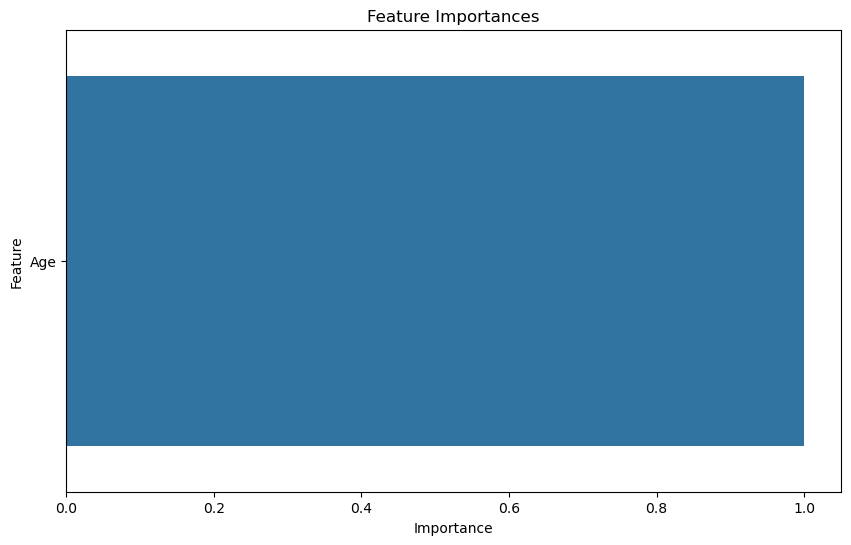

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib

# 1. Load data
data = pd.read_csv('healthcare_dataset.csv')

# 2. Preprocess data
data = data.drop(["Name", "Room Number"], axis=1)

label_encoders = {}
for column in data.select_dtypes(include="object").columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

data['Optimal Fee Package'] = pd.qcut(data['Billing Amount'], q=3, labels=['Low', 'Medium', 'High'])

X = data.drop(["Optimal Fee Package", "Billing Amount"], axis=1)
y = data["Optimal Fee Package"]

# 3. Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Define preprocessing steps
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# 5. Apply SMOTE for class balancing
smote = SMOTE(random_state=42)

# 6. Build the model pipeline
rf_model = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# 7. Perform RandomizedSearchCV for hyperparameter tuning
param_dist = {
    'classifier__n_estimators': np.arange(100, 301, 50),
    'classifier__max_depth': np.arange(5, 21, 5),
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=10, cv=3, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# 8. Evaluate the model
best_model = random_search.best_estimator_
predictions = best_model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

# 9. Perform cross-validation
cv_scores = cross_val_score(best_model, X, y, cv=3)
print("Cross-validation accuracy: ", np.mean(cv_scores))

# 10. Save the trained model
joblib.dump(best_model, 'best_rf_model.pkl')

# 11. Plot feature importance
feature_importances = best_model.named_steps['classifier'].feature_importances_

features = numeric_features.tolist() + categorical_features.tolist()

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=features)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


# 3. Optimize marketing to specific customers

## Basic

In [15]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv('healthcare_dataset.csv')

# Create a new target variable based on Billing Amount
threshold = 5000
df['Target'] = (df['Billing Amount'] > threshold).astype(int)

# Columns to encode
categorical_columns = ['Gender', 'Blood Type', 'Medical Condition', 'Doctor', 
                       'Hospital', 'Insurance Provider', 'Admission Type', 
                       'Medication', 'Test Results']

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode categorical columns to numerical values
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

# Features for training
features = ['Age', 'Room Number', 'Billing Amount'] + categorical_columns

# Split data into training and testing sets
X = df[features]
y = df['Target']

# Split the data (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Print detailed metrics
print(classification_report(y_test, y_pred))

# Display feature importances
feature_importances = rf_model.feature_importances_
print("\nFeature Importances:")
for feature, importance in zip(X.columns, feature_importances):
    print(f"{feature}: {importance:.4f}")


Accuracy: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       864
           1       1.00      1.00      1.00     10236

    accuracy                           1.00     11100
   macro avg       1.00      1.00      1.00     11100
weighted avg       1.00      1.00      1.00     11100


Feature Importances:
Age: 0.0025
Room Number: 0.0031
Billing Amount: 0.9805
Gender: 0.0004
Blood Type: 0.0012
Medical Condition: 0.0012
Doctor: 0.0039
Hospital: 0.0041
Insurance Provider: 0.0009
Admission Type: 0.0006
Medication: 0.0009
Test Results: 0.0007


## Advanced

In [17]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Read the data
df = pd.read_csv('healthcare_dataset.csv')

# Create target variable based on Billing Amount
threshold = 5000
df['Target'] = (df['Billing Amount'] > threshold).astype(int)

# Columns to encode
categorical_columns = ['Gender', 'Blood Type', 'Medical Condition', 'Doctor', 
                       'Hospital', 'Insurance Provider', 'Admission Type', 
                       'Medication', 'Test Results']

# Select features for training the model
features = ['Age', 'Room Number', 'Billing Amount'] + categorical_columns

# Split the data into features and target
X = df[features]
y = df['Target']

# Split the data into training and testing sets (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build a pipeline for preprocessing and the model
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), X.select_dtypes(include=['float64', 'int64']).columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])

# Create a pipeline with preprocessing and Random Forest model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define parameters for RandomizedSearchCV
param_dist = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__bootstrap': [True, False]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=5, cv=3, random_state=42, n_jobs=-1)

# Train the model with RandomizedSearchCV
random_search.fit(X_train, y_train)

# Make predictions on the test set
y_pred = random_search.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Print detailed classification metrics (precision, recall, f1-score)
print(classification_report(y_test, y_pred))

# Cross-validation
cv_scores = cross_val_score(random_search.best_estimator_, X, y, cv=3, scoring='accuracy', n_jobs=-1)
print(f'Cross-Validation Accuracy: {cv_scores.mean() * 100:.2f}%')

# Print the best parameters from RandomizedSearchCV
print(f"Best Parameters from RandomizedSearchCV: {random_search.best_params_}")

# If you want to check the feature importances
feature_importances = random_search.best_estimator_.named_steps['classifier'].feature_importances_
print("\nFeature Importances:")
for feature, importance in zip(X.columns, feature_importances):
    print(f"{feature}: {importance:.4f}")


Accuracy: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       864
           1       1.00      1.00      1.00     10236

    accuracy                           1.00     11100
   macro avg       1.00      1.00      1.00     11100
weighted avg       1.00      1.00      1.00     11100

Cross-Validation Accuracy: 99.98%
Best Parameters from RandomizedSearchCV: {'classifier__n_estimators': 50, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': None, 'classifier__bootstrap': False}

Feature Importances:
Age: 0.0003
Room Number: 0.0004
Billing Amount: 0.9011
Gender: 0.0001
Blood Type: 0.0001
Medical Condition: 0.0001
Doctor: 0.0001
Hospital: 0.0001
Insurance Provider: 0.0001
Admission Type: 0.0000
Medication: 0.0001
Test Results: 0.0001


# 4. Identify and prevent fraudulent claim activities

## Basic

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv('healthcare_dataset.csv')

# Create the target variable "Fraudulent Claim"
threshold_billing = 10000
df['Fraudulent Claim'] = ((df['Billing Amount'] > threshold_billing) & 
                           (df['Insurance Provider'].str.contains('Untrusted|Fake', case=False)))
df['Fraudulent Claim'] = df['Fraudulent Claim'].astype(int)

# Encode categorical columns
categorical_columns = ['Gender', 'Blood Type', 'Medical Condition', 'Doctor', 
                       'Hospital', 'Insurance Provider', 'Admission Type', 
                       'Medication', 'Test Results']
label_encoder = LabelEncoder()
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

# Define features and target variable
features = ['Age', 'Room Number', 'Billing Amount'] + categorical_columns
X = df[features]
y = df['Fraudulent Claim']

# Split the data into training and testing sets (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Print detailed classification report
print(classification_report(y_test, y_pred))


Accuracy: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11100

    accuracy                           1.00     11100
   macro avg       1.00      1.00      1.00     11100
weighted avg       1.00      1.00      1.00     11100



## Advanced

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Load the dataset
df = pd.read_csv('healthcare_dataset.csv')

# Create target "Fraudulent Claim"
threshold_billing = 10000
df['Fraudulent Claim'] = ((df['Billing Amount'] > threshold_billing) & 
                           (df['Insurance Provider'].str.contains('Untrusted|Fake', case=False)))
df['Fraudulent Claim'] = df['Fraudulent Claim'].astype(int)

# Categorical columns to encode
categorical_columns = ['Gender', 'Blood Type', 'Medical Condition', 'Doctor', 
                       'Hospital', 'Insurance Provider', 'Admission Type', 
                       'Medication', 'Test Results']

# Select features for training the model
features = ['Age', 'Room Number', 'Billing Amount'] + categorical_columns

# Split the dataset into features and target
X = df[features]
y = df['Fraudulent Claim']

# Split the data into training and testing sets (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), X.select_dtypes(include=['float64', 'int64']).columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])

# Create a pipeline with Random Forest classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))  # Utilize multiple cores
])

# Define parameters for RandomizedSearchCV
param_dist = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__bootstrap': [True, False]
}

# Initialize RandomizedSearchCV with n_iter=5 for fewer iterations
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=5, cv=3, random_state=42, n_jobs=-1)

# Train the model with RandomizedSearchCV
random_search.fit(X_train, y_train)

# Predict on the test set
y_pred = random_search.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Display classification report (precision, recall, f1-score)
print(classification_report(y_test, y_pred))

# Display the best parameters from RandomizedSearchCV
print(f"Best Parameters from RandomizedSearchCV: {random_search.best_params_}")

# Display feature importances
feature_importances = random_search.best_estimator_.named_steps['classifier'].feature_importances_
print("\nFeature Importances:")
for feature, importance in zip(X.columns, feature_importances):
    print(f"{feature}: {importance:.4f}")


Accuracy: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11100

    accuracy                           1.00     11100
   macro avg       1.00      1.00      1.00     11100
weighted avg       1.00      1.00      1.00     11100

Best Parameters from RandomizedSearchCV: {'classifier__n_estimators': 50, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'sqrt', 'classifier__max_depth': None, 'classifier__bootstrap': False}

Feature Importances:
Age: 0.0000
Room Number: 0.0000
Billing Amount: 0.0000
Gender: 0.0000
Blood Type: 0.0000
Medical Condition: 0.0000
Doctor: 0.0000
Hospital: 0.0000
Insurance Provider: 0.0000
Admission Type: 0.0000
Medication: 0.0000
Test Results: 0.0000
